# Exploratory Data Analysis (EDA) – N₂O Concentration

This analysis investigates key characteristics of the measurement data from the Altenrhein wastewater treatment plant:

- **Time trends**
- **Distributions**
- **Outliers**
- **Autocorrelation**
- **Correlations**

## imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import autocorrelation_plot
from pathlib import Path
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler

## data load

In [2]:
def load_wwtp_data_auto(filepath, time_column='TIME'):
    """
    Loads a CSV, parses the time column, and keeps all other columns.
    Automatically detects and keeps all data columns except for the time column.
    """
    df = pd.read_csv(filepath)
    if time_column not in df.columns:
        raise ValueError(f"Column '{time_column}' not found in data.")
    df[time_column] = pd.to_datetime(df[time_column])
    # Select all columns except the time column
    data_columns = [col for col in df.columns if col != time_column]
    # Ensure time column is first
    df = df[[time_column] + data_columns]
    df = df.sort_values(time_column).reset_index(drop=True)
    return df

# Usage
data_path = Path("..") / "data" / "AltenrheinWWTP.csv"
df = load_wwtp_data_auto(data_path)
df.head()

# Optional: Dictionary of column names and nicer plot labels, if you want
labels = {
    'N2O': 'N₂O [kgN/h]',
    'DO': 'DO [mgO₂/l]',
    'Q_in': 'Q_in [l/s]',
    'T': 'Temperature [°C]'
}

## missing, negative, and duplicate Checks

In [3]:
numeric_columns = [col for col in df.columns if col != 'TIME' and pd.api.types.is_numeric_dtype(df[col])]
nan_counts = df[numeric_columns].isnull().sum()
nan_ratios = df[numeric_columns].isnull().mean() * 100
missing_table = pd.DataFrame({
    'Missing Values': nan_counts,
    'Percentage [%]': nan_ratios.round(2)
})
display(missing_table)
num_duplicates = df.duplicated().sum()
print(f"Duplicates: {num_duplicates}")

neg_counts = (df[numeric_columns] < 0).sum()
print("\nNegative values per numeric variable:")
print(neg_counts)
for col in numeric_columns:
    neg_examples = df[df[col] < 0][[col]].head()
    if not neg_examples.empty:
        print(f"\n🔬 Example negative values in {col}:")
        display(neg_examples)

,Missing Values,Percentage [%]
N2O,2382,6.78
DO,78,0.22
Q_in,78,0.22
T,78,0.22


Duplicates: 0

Negative values per numeric variable:
N2O     984
DO        0
Q_in      0
T         0
dtype: int64

🔬 Example negative values in N2O:


,N2O
1693,-0.000173
1694,-0.000257
1695,-0.000379
1696,-0.000497
1697,-0.000532


## data cleaning

In [4]:
# --- Data Cleaning ---
df_clean = df.dropna(subset=numeric_columns)
for col in numeric_columns:
    df_clean = df_clean[df_clean[col] >= 0]
df_clean = df_clean.reset_index(drop=True)
print(f"✅ Cleaned data – remaining rows: {len(df_clean)}")
display(df_clean.head())
neg_counts_clean = (df_clean[numeric_columns] < 0).sum()
print("\nNegative values per numeric variable (cleaned):")
print(neg_counts_clean)

✅ Cleaned data – remaining rows: 31770


,TIME,N2O,DO,Q_in,T
0,2016-01-01 00:00:00,0.505882,2.118750,23.312500,12.856250
1,2016-01-01 00:15:00,0.494209,2.113333,17.733333,12.813333
2,2016-01-01 00:30:00,0.507373,1.964286,24.928571,12.814286
3,2016-01-01 00:45:00,0.524761,1.900000,25.600000,12.900000
4,2016-01-01 01:00:00,0.540889,2.046667,29.733333,12.900000



Negative values per numeric variable (cleaned):
N2O     0
DO      0
Q_in    0
T       0
dtype: int64


## time series plots

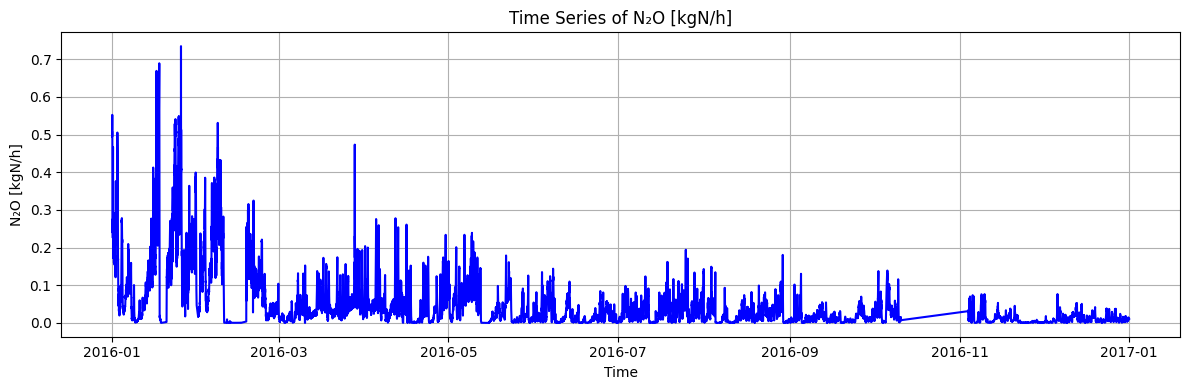

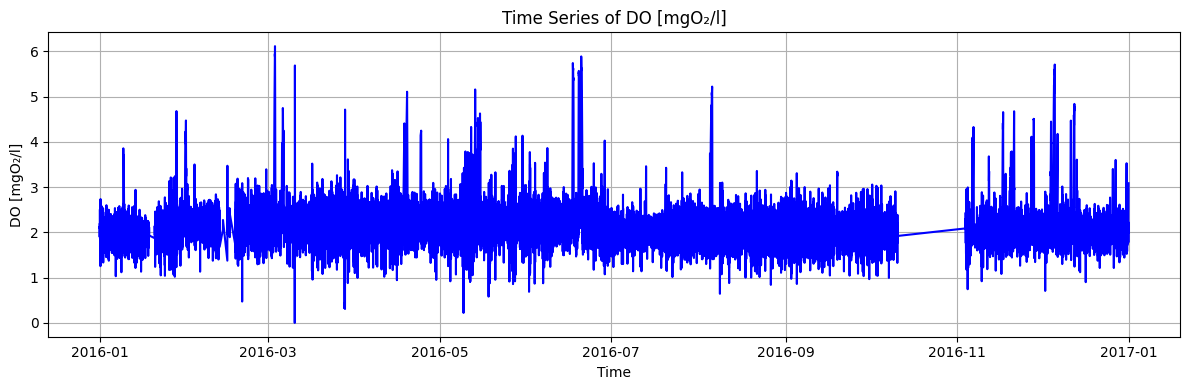

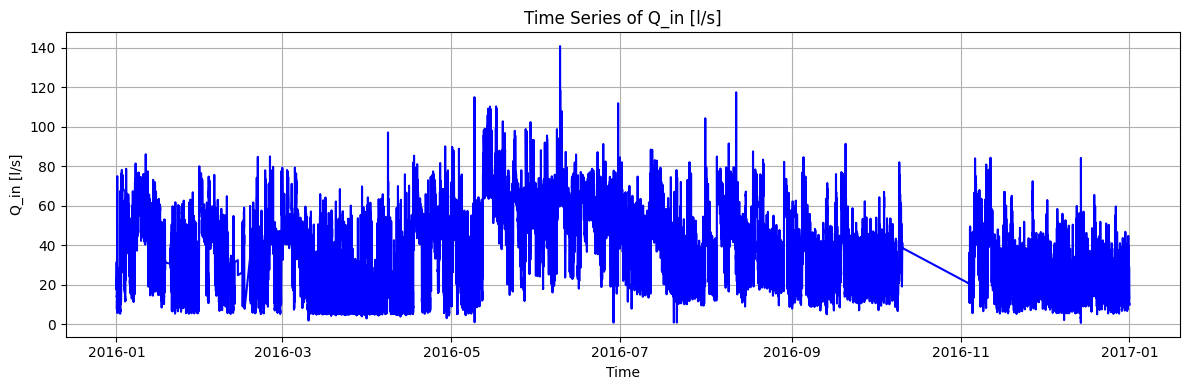

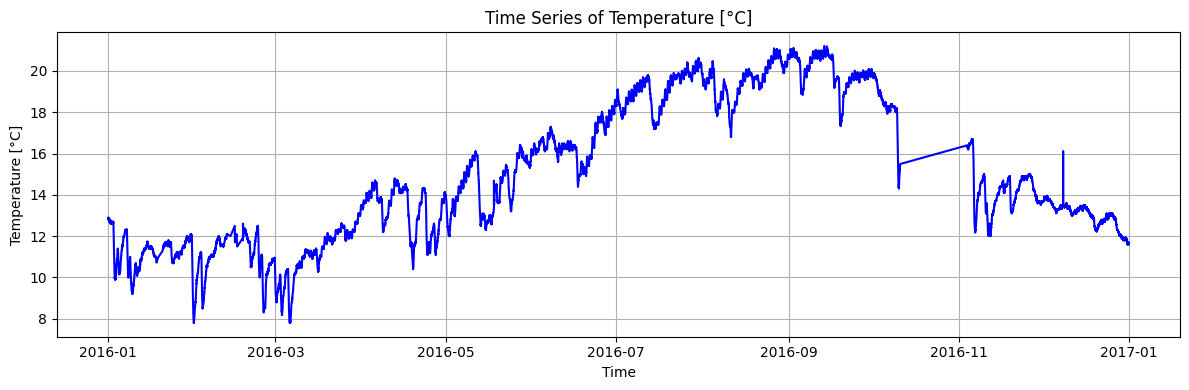

In [5]:
for col in ['N2O', 'DO', 'Q_in', 'T']:
    plt.figure(figsize=(12, 4))
    plt.plot(df_clean['TIME'], df_clean[col], color='blue')
    plt.title(f'Time Series of {labels.get(col, col)}')
    plt.xlabel('Time')
    plt.ylabel(labels.get(col, col))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## histograms

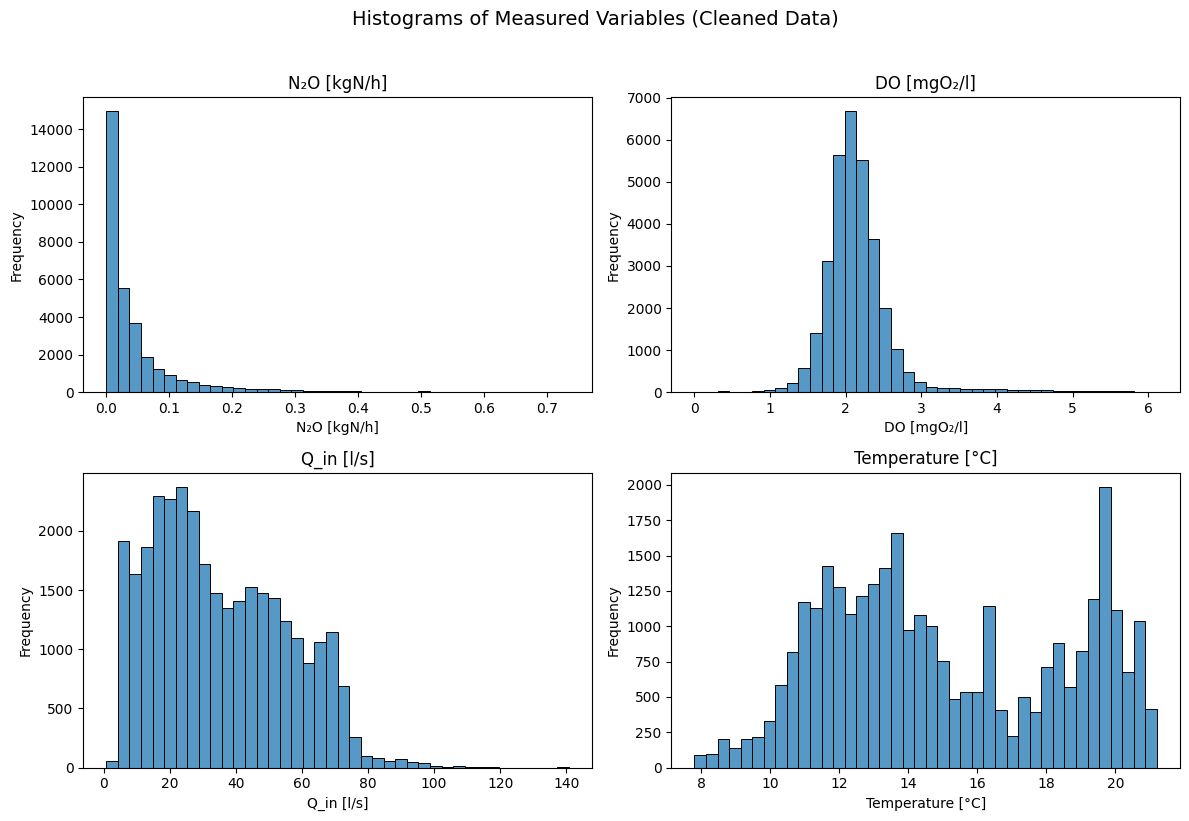

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(numeric_columns):
    ax = axes[i // 2, i % 2]
    sns.histplot(df_clean[col], bins=40, kde=False, ax=ax)
    ax.set_title(labels.get(col, col))
    ax.set_xlabel(labels.get(col, col))
    ax.set_ylabel("Frequency")
plt.suptitle('Histograms of Measured Variables (Cleaned Data)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## cross-correlation

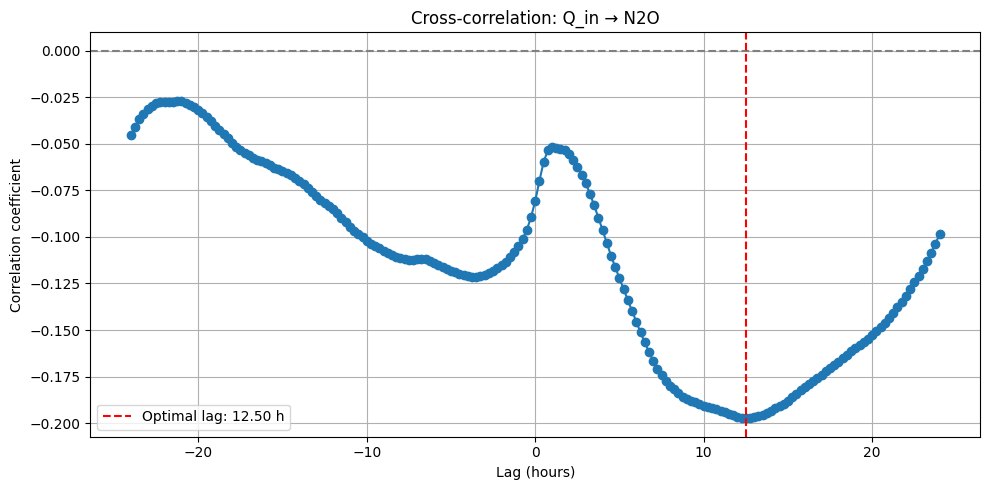

Maximum correlation: -0.197
Optimal lag: 50 steps = 12.50 hours


In [7]:
def cross_correlation(df, var1, var2, time_step_min=15, max_lag_hours=24):
    df_corr = df[[var1, var2]].dropna()
    if df_corr[var1].std() == 0 or df_corr[var2].std() == 0:
        print("Warning: One of the series has zero standard deviation.")
        return
    v1_z = (df_corr[var1] - df_corr[var1].mean()) / df_corr[var1].std()
    v2_z = (df_corr[var2] - df_corr[var2].mean()) / df_corr[var2].std()
    max_lag = int(max_lag_hours * 60 / time_step_min)
    lags = np.arange(-max_lag, max_lag + 1)
    correlations = [v2_z.shift(lag).corr(v1_z) for lag in lags]
    max_corr = max(correlations, key=abs)
    optimal_lag = lags[np.argmax(np.abs(correlations))]
    optimal_lag_hours = optimal_lag * time_step_min / 60

    plt.figure(figsize=(10, 5))
    plt.plot(lags * time_step_min / 60, correlations, marker='o')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(optimal_lag_hours, color='red', linestyle='--', 
                label=f'Optimal lag: {optimal_lag_hours:.2f} h')
    plt.xlabel('Lag (hours)')
    plt.ylabel('Correlation coefficient')
    plt.title(f'Cross-correlation: {var2} → {var1}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Maximum correlation: {max_corr:.3f}")
    print(f"Optimal lag: {optimal_lag} steps = {optimal_lag_hours:.2f} hours")
cross_correlation(df, 'N2O', 'Q_in')

## autocorrelation

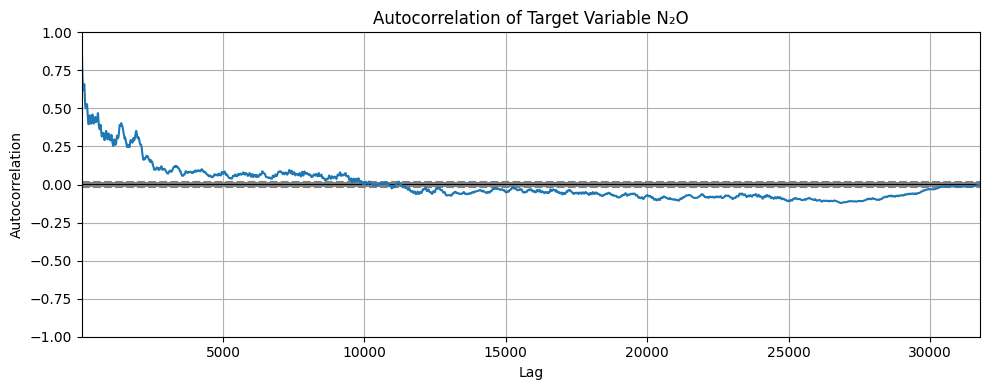

In [8]:
plt.figure(figsize=(10, 4))
autocorrelation_plot(df_clean['N2O'].dropna())
plt.title('Autocorrelation of Target Variable N₂O')
plt.tight_layout()
plt.show()

## descriptive statistics

In [9]:
desc_stats = df[numeric_columns].describe().T
desc_stats['median'] = df[numeric_columns].median()
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['kurt'] = df[numeric_columns].kurt()
summary = desc_stats[['std', 'kurt', 'max', 'min', 'mean', 'median', 'range']]
summary.columns = ['STD', 'Kurtosis', 'Max', 'Min', 'Mean', 'Median', 'Range']
summary.index.name = 'Parameter'
display(summary.round(3))

,STD,Kurtosis,Max,Min,Mean,Median,Range
Parameter,,,,,,,
N2O,0.072,14.639,0.735,-0.001,0.045,0.019,0.736
DO,0.495,14.289,6.113,0.000,2.156,2.087,6.113
Q_in,19.903,-0.489,140.733,0.812,34.482,30.200,139.921
T,3.334,-1.163,21.200,7.800,15.080,14.500,13.400


## correlation matrix heatmap

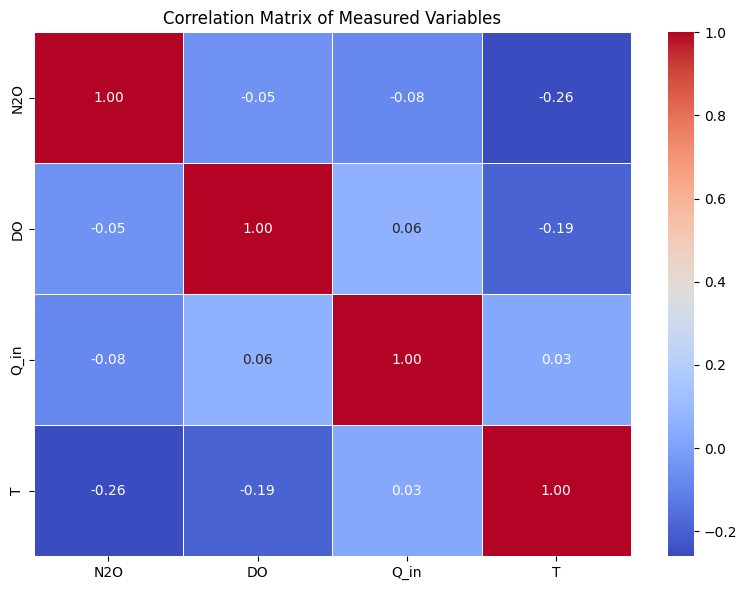

In [10]:
corr_matrix = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5
)
plt.title('Correlation Matrix of Measured Variables')
plt.tight_layout()
plt.show()

## outlier detection

### Boxplots

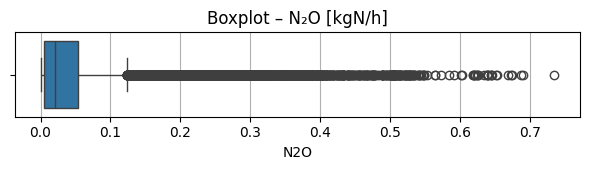

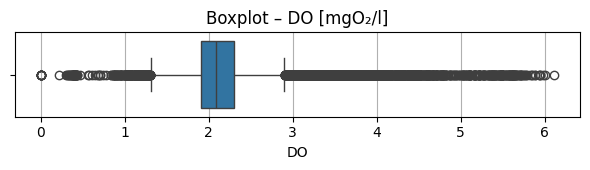

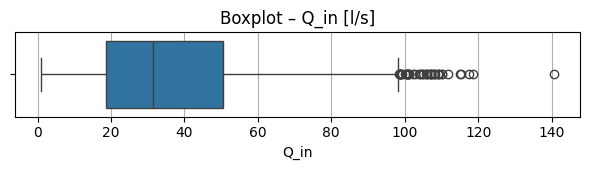

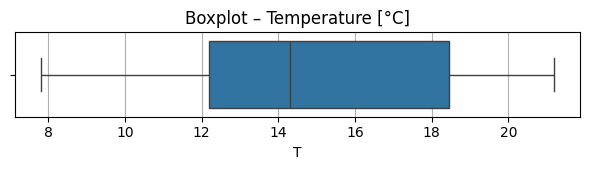

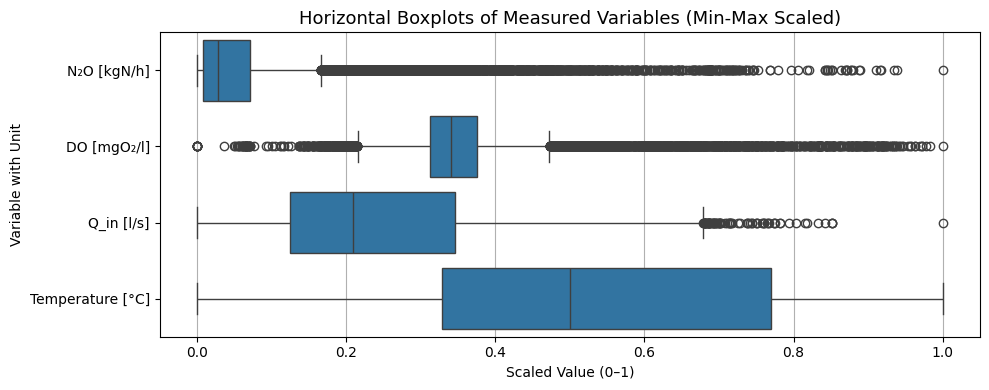

In [11]:
for col in numeric_columns:
    plt.figure(figsize=(6, 1.8))
    sns.boxplot(x=df_clean[col], orient='h')
    plt.title(f'Boxplot – {labels.get(col, col)}')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[list(labels.keys())] = scaler.fit_transform(df[list(labels.keys())])
df_scaled = df_scaled.rename(columns=labels)
df_long_scaled = df_scaled.melt(
    id_vars='TIME',
    value_vars=list(labels.values()),
    var_name='Variable',
    value_name='Scaled Value'
)
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_long_scaled, y='Variable', x='Scaled Value', orient='h')
plt.title('Horizontal Boxplots of Measured Variables (Min-Max Scaled)', fontsize=13)
plt.xlabel('Scaled Value (0–1)')
plt.ylabel('Variable with Unit')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

### IQR-Method

In [12]:
def remove_outliers_iqr(df, labels):
    df_filtered = df.copy()
    initial_rows = df_filtered.shape[0]

    for col, label in labels.items():
        Q1, Q3 = df_filtered[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before = df_filtered.shape[0]
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
        after = df_filtered.shape[0]
        print(f"Outlier removal for {label} (IQR method):")
        print(f"  Bounds -> Lower: {lower_bound:.4f}, Upper: {upper_bound:.4f}")
        print(f"  Removed {before - after} rows\n")

    print(f"Total rows removed: {initial_rows - df_filtered.shape[0]}")
    print(f"Rows remaining: {df_filtered.shape[0]}")
    return df_filtered
df_filtered = remove_outliers_iqr(df_clean, labels)

Outlier removal for N₂O [kgN/h] (IQR method):
  Bounds -> Lower: -0.0654, Upper: 0.1239
  Removed 3137 rows

Outlier removal for DO [mgO₂/l] (IQR method):
  Bounds -> Lower: 1.2800, Upper: 2.9333
  Removed 1439 rows

Outlier removal for Q_in [l/s] (IQR method):
  Bounds -> Lower: -28.1333, Upper: 97.7333
  Removed 32 rows

Outlier removal for Temperature [°C] (IQR method):
  Bounds -> Lower: 3.5973, Upper: 28.1378
  Removed 0 rows

Total rows removed: 4608
Rows remaining: 27162


### Mahalanobis

Mahalanobis distance threshold (0.990 quantile): 3.64
Number of detected multivariate outliers: 176


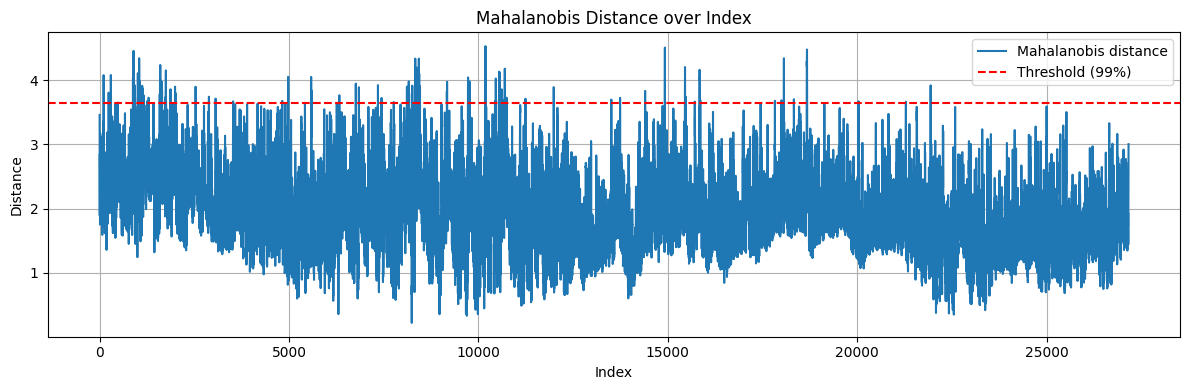

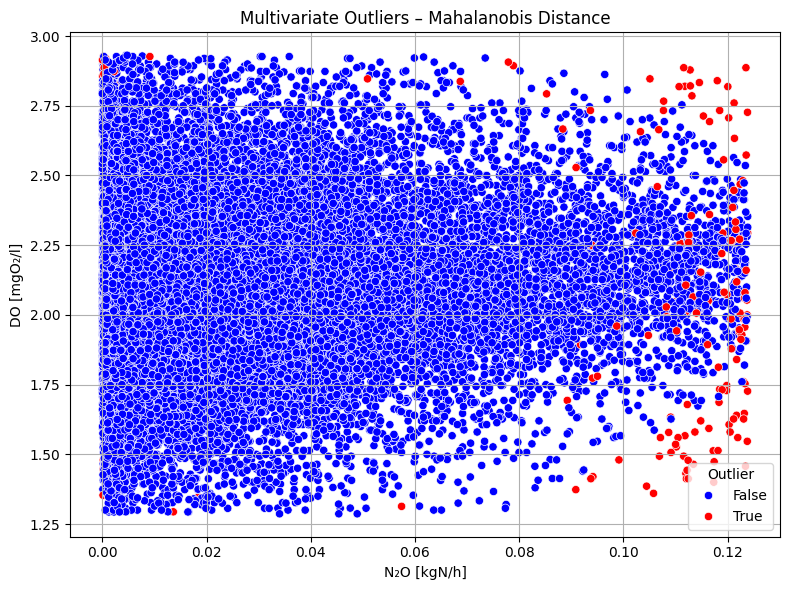

In [13]:
def detect_mahalanobis_outliers(df, numeric_columns, quantile=0.99, verbose=True):
    df_features = df[numeric_columns].copy()
    df_features = df_features.loc[:, df_features.std() > 0]  # remove constant columns
    df_features = df_features.dropna().reset_index(drop=True)
    X = df_features.values
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        if verbose:
            print("Covariance matrix is not invertible. Using pseudo-inverse.")
        cov_inv = np.linalg.pinv(cov)
    distances = np.array([mahalanobis(x, mu, cov_inv) for x in X])
    threshold = np.sqrt(chi2.ppf(quantile, df=X.shape[1]))
    outlier_mask = distances > threshold
    df_out = df_features.copy()
    df_out['Mahalanobis_Distance'] = distances
    df_out['Outlier'] = outlier_mask
    if verbose:
        print(f"Mahalanobis distance threshold ({quantile:.3f} quantile): {threshold:.2f}")
        print(f"Number of detected multivariate outliers: {outlier_mask.sum()}")
    return df_out
df_mahal = detect_mahalanobis_outliers(df_filtered, numeric_columns)

# Line plot of Mahalanobis distances
plt.figure(figsize=(12, 4))
sns.lineplot(x=range(len(df_mahal)), y=df_mahal['Mahalanobis_Distance'], label='Mahalanobis distance')
plt.axhline(y=np.sqrt(chi2.ppf(0.99, df=len(numeric_columns))), color='red', linestyle='--', label='Threshold (99%)')
plt.title('Mahalanobis Distance over Index')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatterplot (only works if 'N2O' and 'DO' exist in df_mahal)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_mahal, x='N2O', y='DO', hue='Outlier', palette={False: 'blue', True: 'red'})
plt.title('Multivariate Outliers – Mahalanobis Distance')
plt.xlabel(labels.get('N2O', 'N2O'))
plt.ylabel(labels.get('DO', 'DO'))
plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()